In [1]:
import pandas as pd
df = pd.read_csv('/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/charlene_work/homer_output_mouse.tsv',
                 sep = '\t')

In [2]:
df.head()

,FASTA ID,Offset,Sequence,Motif Name,Strand,MotifScore
0,5715170,-14,GGTAAGGT,ZRANB2_GGTAAGGT,+,10.117872
1,5715169,1,GGTAAGGT,ZRANB2_GGTAAGGT,+,10.117872
2,5660671,-13,GGTAAGGT,ZRANB2_GGTAAGGT,+,10.117872
3,5660670,2,GGTAAGGT,ZRANB2_GGTAAGGT,+,10.117872
4,5658612,-5,GGTAAGGT,ZRANB2_GGTAAGGT,+,10.117872


In [3]:
import pandas as pd
from plot_params import *
import pandas as pd
data=pd.read_csv(outdir / 'Mouse_annotated.csv.gz', index_col = 0)

In [4]:
data.head()

,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq
0,ENSMUST00000000001,0,30,0.001099,0.030640,UTR5,UTR5,CACACATCCGGTTCTTCCGGGAGCTAGGGG
1,ENSMUST00000000001,15,45,0.001587,0.031128,UTR5,UTR5,TCCGGGAGCTAGGGGAGCTGACGGAGAAGG
2,ENSMUST00000000001,30,60,-0.001343,0.028198,UTR5,UTR5,AGCTGACGGAGAAGGCCACCGCCCAGCAGA
3,ENSMUST00000000001,45,75,-0.001099,0.028442,UTR5,UTR5,CCACCGCCCAGCAGAAGACCCGTCTCCGCC
4,ENSMUST00000000001,60,90,0.002197,0.031738,UTR5,UTR5,AGACCCGTCTCCGCCGGTGTGTGGCGATTC


In [5]:
data['annotation']=data.apply(
    lambda row: 'UTR5' if row['start_annotation']=='UTR5' and row['end_annotation']=='UTR5' else
     'UTR3' if row['start_annotation']=='UTR3' and row['end_annotation']=='UTR3' else 'CDS', axis = 1)

In [6]:
import numpy as np
data['difference_bin'] = pd.cut(data['difference'], bins = [-np.inf, -0.1, 0.1, np.inf],
                               labels = ['<-0.1', 'middle', '>0.1'])

In [7]:
data

,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq,annotation,difference_bin
0,ENSMUST00000000001,0,30,0.001099,0.030640,UTR5,UTR5,CACACATCCGGTTCTTCCGGGAGCTAGGGG,UTR5,middle
1,ENSMUST00000000001,15,45,0.001587,0.031128,UTR5,UTR5,TCCGGGAGCTAGGGGAGCTGACGGAGAAGG,UTR5,middle
2,ENSMUST00000000001,30,60,-0.001343,0.028198,UTR5,UTR5,AGCTGACGGAGAAGGCCACCGCCCAGCAGA,UTR5,middle
3,ENSMUST00000000001,45,75,-0.001099,0.028442,UTR5,UTR5,CCACCGCCCAGCAGAAGACCCGTCTCCGCC,UTR5,middle
4,ENSMUST00000000001,60,90,0.002197,0.031738,UTR5,UTR5,AGACCCGTCTCCGCCGGTGTGTGGCGATTC,UTR5,middle
...,...,...,...,...,...,...,...,...,...,...
5722825,ENSMUST00020183810,540,570,0.003906,0.129883,UTR3,UTR3,TCATCGATGACACCGACCTGGAAGAAGATG,UTR3,middle
5722826,ENSMUST00020183810,555,585,0.003906,0.129883,UTR3,UTR3,ACCTGGAAGAAGATGCCGCGCTCAAGCAGA,UTR3,middle
5722827,ENSMUST00020183810,570,600,0.003906,0.129883,UTR3,UTR3,CCGCGCTCAAGCAGAACTCGAGCCCGCCGT,UTR3,middle
5722828,ENSMUST00020183810,585,615,0.003906,0.129883,UTR3,UTR3,ACTCGAGCCCGCCGTCCTCGCTCAACAAGA,UTR3,middle


<Axes: >

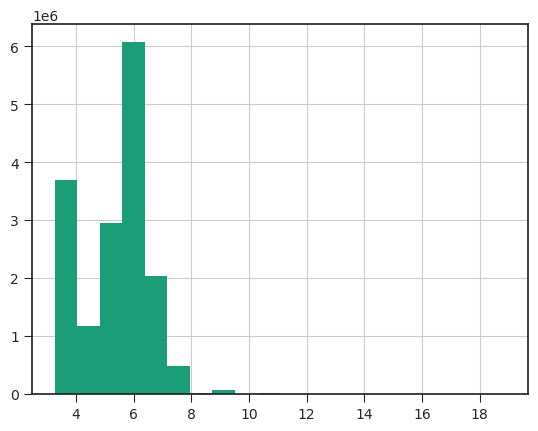

In [8]:
df['MotifScore'].hist(bins = 20)

In [9]:
from scipy.stats import fisher_exact,chisquare
def testing(df):
    ''' perform fisher exact or chisq given contingency table'''
    if df.shape != (2,2):
        # some outcomes are unobserved
        print(df.shape)
        print('no binding is observed in')
        return 1, np.nan
    if df.le(5).any().any():
        odds_ratio, pvalue = fisher_exact(df)
    else:
        chi, pvalue = chisquare(df.loc[True], (df.loc[True].sum())*df.loc[False].div(df.loc[False].sum()))
        odds_ratio = (df.loc[True, True]/df.loc[True, False])/(df.loc[False, True]/df.loc[False, False])
    return pvalue, odds_ratio


## Build contingency table:
| has motif + different (difference either < -0.1 or > 0.1)            | different w/ no motif     |
|----------------------------------------------------------------------|---------------------------|
| has motif + not different (difference between -0.1 and 0.1) "middle" | not different w/ no motif |

Generates p-values and log-odds ratio for each condition, significant = motif found in hotspot not random

In [10]:
from tqdm import trange

stat_individual = []
progress = trange(len(df['Motif Name'].unique()), leave=False, position=0)
for exp in df['Motif Name'].unique():
    for cat in ['<-0.1', '>0.1']:
        has_motif = set(df.loc[df['Motif Name']==exp, 'FASTA ID'])
        
        positive = set(data.loc[(data['difference_bin']==cat),].index)
        negative = set(data.loc[(data['difference_bin']=='middle')].index)
                                    
        contingency = pd.DataFrame(np.array([[len(has_motif.intersection(positive)), len(positive-has_motif)],
                              [len(has_motif.intersection(negative)), len(negative-has_motif)]]
                             ),
                                   index = [True, False],
                                   columns = [True, False]
                                  )
        pv, or_ = testing(contingency)
        stat_individual.append([exp, cat, pv, or_])
    progress.set_description(exp)
    progress.update(1)
    
stat_individual = pd.DataFrame(stat_individual,columns = ['experiment', 'category', 'p-value', 'odds ratio']) 
stat_individual.head()

ZFP36_TATTTA: 100%|██████████| 98/98 [10:40<00:00,  4.49s/it]         

,experiment,category,p-value,odds ratio
0,ZRANB2_GGTAAGGT,<-0.1,0.275737,0.000000
1,ZRANB2_GGTAAGGT,>0.1,1.000000,0.000000
2,ZFP36_TATTTATT,<-0.1,0.016487,0.506947
3,ZFP36_TATTTATT,>0.1,0.342046,0.443992
4,CELF3_GTGTGTGT,<-0.1,0.005394,0.541760


In [11]:
stat_individual = pd.DataFrame(
    stat_individual,columns = ['experiment', 'category', 'p-value', 'odds ratio']) 

In [12]:
from statsmodels.stats.multitest import fdrcorrection
fdr_thres = 0.2
stat_individual['sig'],stat_individual['FDR'] = fdrcorrection(stat_individual['p-value'], alpha = fdr_thres)
stat_individual['l2or'] = np.log2(stat_individual['odds ratio'])
stat_individual['-log10 FDR']= -np.log10(stat_individual['FDR']+stat_individual.loc[stat_individual['FDR']>0, 'FDR'].min())

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
syngo = pd.read_excel('synGo/syngo_genes.xlsx')

In [14]:
stat_individual['RBP'] = stat_individual['experiment'].str.split('_', expand = True)[0]

In [15]:
stat_individual['is_SynGO']=stat_individual['RBP'].isin(syngo['hgnc_symbol'])

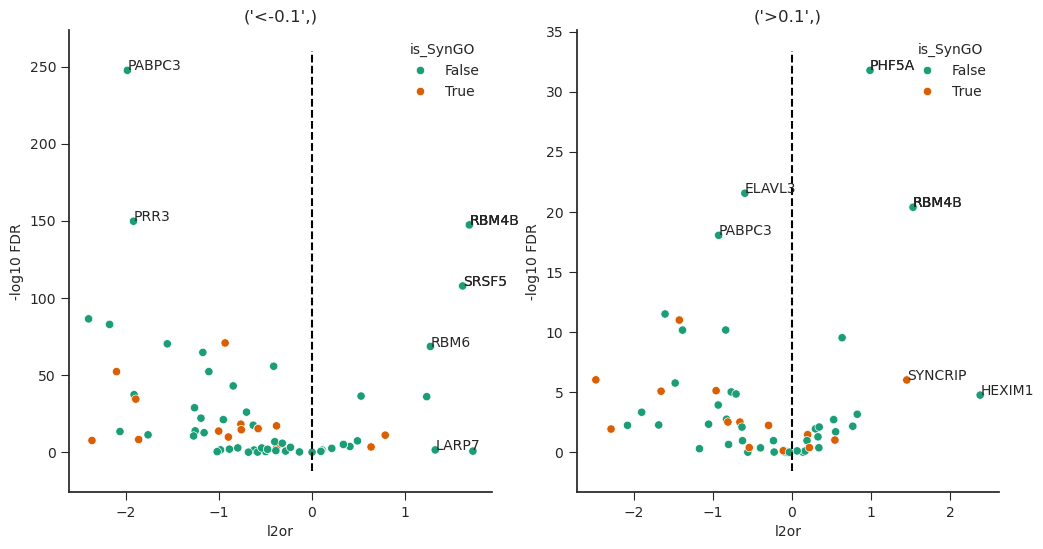

In [16]:
f, axes = plt.subplots(1,2, figsize = (12,6))
for ax, (name, group) in zip(axes.flatten(),stat_individual.groupby(by = ['category'])):
    sns.scatterplot(data = group, x = 'l2or', y = '-log10 FDR', ax = ax, hue = 'is_SynGO')
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'odds ratio', ascending = False).iloc[:5]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:5]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['l2or'], row['-log10 FDR'], row['experiment'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()

In [17]:
outdir

PosixPath('/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/charlene_work')

In [18]:
stat_individual.to_csv(outdir / 'motif_enrichment_human_all.csv')

In [19]:
stat_individual.loc[(stat_individual['sig'])&(stat_individual['category']=='<-0.1')
].sort_values(by = 'odds ratio')

,experiment,category,p-value,odds ratio,sig,FDR,l2or,-log10 FDR,RBP,is_SynGO
6,MEX3D_TTGTTTATT,<-0.1,3.894821e-02,0.000000,True,7.068378e-02,-inf,1.150680,MEX3D,False
44,KHDRBS2_TAAAA,<-0.1,1.091593e-88,0.189691,True,3.565872e-87,-2.398279,86.447834,KHDRBS2,False
46,ELAVL1_TTTTGTTT,<-0.1,7.752747e-09,0.194508,True,2.665857e-08,-2.362099,7.574163,ELAVL1,True
172,PABPN1L_AAAAA,<-0.1,5.637448e-85,0.221812,True,1.381175e-83,-2.172589,82.859751,PABPN1L,False
142,ZC3H11A_AAAAA,<-0.1,5.637448e-85,0.221812,True,1.381175e-83,-2.172589,82.859751,ZC3H11A,False
...,...,...,...,...,...,...,...,...,...,...
150,RBM6_CGTCC,<-0.1,1.515372e-70,2.421936,True,2.700118e-69,1.276161,68.568617,RBM6,False
42,LARP7_TCGTGATG,<-0.1,1.952705e-02,2.511046,True,3.680097e-02,1.328289,1.434141,LARP7,False
86,SRSF5_GCCGCC,<-0.1,3.946382e-110,3.080285,True,1.546982e-108,1.623064,107.810515,SRSF5,False
144,RBM4_GCGCG,<-0.1,8.070241e-150,3.238170,True,3.954418e-148,1.695179,147.402917,RBM4,False


In [20]:
stat = []
for exp in df['Motif Name'].unique():
    for annotation in ['UTR5', 'CDS', 'UTR3']:
        for cat in ['<-0.1', '>0.1']:
            has_motif = set(df.loc[df['Motif Name']==exp, 'FASTA ID'])
            
            positive = set(data.loc[(data['annotation']==annotation)&
                                        (data['difference_bin']==cat),
                                        ].index)
            negative = set(data.loc[(data['annotation']==annotation)&
                                        (data['difference_bin']=='middle')].index)
                                        
            contingency = pd.DataFrame(np.array([[len(has_motif.intersection(positive)), len(positive-has_motif)],
                                  [len(has_motif.intersection(negative)), len(negative-has_motif)]]
                                 ),
                                       index = [True, False],
                                       columns = [True, False]
                                      )
        
            pv, or_ = testing(contingency)
            stat.append([annotation, exp, cat, pv, or_])
            print(exp)
stat = pd.DataFrame(stat,columns = ['annotation', 'experiment', 'category', 'p-value', 'odds ratio']) 

ZRANB2_GGTAAGGT
ZRANB2_GGTAAGGT
ZRANB2_GGTAAGGT
ZRANB2_GGTAAGGT
ZRANB2_GGTAAGGT
ZRANB2_GGTAAGGT
ZFP36_TATTTATT
ZFP36_TATTTATT
ZFP36_TATTTATT
ZFP36_TATTTATT
ZFP36_TATTTATT
ZFP36_TATTTATT
CELF3_GTGTGTGT
CELF3_GTGTGTGT
CELF3_GTGTGTGT
CELF3_GTGTGTGT
CELF3_GTGTGTGT
CELF3_GTGTGTGT
MEX3D_TTGTTTATT
MEX3D_TTGTTTATT
MEX3D_TTGTTTATT
MEX3D_TTGTTTATT
MEX3D_TTGTTTATT
MEX3D_TTGTTTATT
CSTF2T_CGTAGCGT
CSTF2T_CGTAGCGT
CSTF2T_CGTAGCGT
CSTF2T_CGTAGCGT
CSTF2T_CGTAGCGT
CSTF2T_CGTAGCGT
ZC3H8_GCTTGC
ZC3H8_GCTTGC
ZC3H8_GCTTGC
ZC3H8_GCTTGC
ZC3H8_GCTTGC
ZC3H8_GCTTGC
TARDBP_GTGTGAATGG
TARDBP_GTGTGAATGG
TARDBP_GTGTGAATGG
TARDBP_GTGTGAATGG
TARDBP_GTGTGAATGG
TARDBP_GTGTGAATGG
CSTF2_AGGCGTAGCGT
CSTF2_AGGCGTAGCGT
CSTF2_AGGCGTAGCGT
CSTF2_AGGCGTAGCGT
CSTF2_AGGCGTAGCGT
CSTF2_AGGCGTAGCGT
HEXIM2_GCGACGGT
HEXIM2_GCGACGGT
HEXIM2_GCGACGGT
HEXIM2_GCGACGGT
HEXIM2_GCGACGGT
HEXIM2_GCGACGGT
YBX2_TAACATC
YBX2_TAACATC
YBX2_TAACATC
YBX2_TAACATC
YBX2_TAACATC
YBX2_TAACATC
SART3_GTTAGC
SART3_GTTAGC
SART3_GTTAGC
SART3_GTTAGC
SART3_GTTAGC

In [21]:
from statsmodels.stats.multitest import fdrcorrection
fdr_thres = 0.2
stat['sig'],stat['FDR'] = fdrcorrection(stat['p-value'], alpha = fdr_thres)

In [22]:
stat.loc[stat['sig']]

,annotation,experiment,category,p-value,odds ratio,sig,FDR
32,CDS,ZC3H8_GCTTGC,<-0.1,1.852084e-46,2.632938,True,8.377119e-45
35,UTR3,ZC3H8_GCTTGC,>0.1,3.611925e-02,4.250111,True,1.449558e-01
54,UTR5,YBX2_TAACATC,<-0.1,5.697489e-05,20.594055,True,5.583539e-04
66,UTR5,ELAVL4_TTTATT,<-0.1,3.568408e-03,2.705862,True,2.098224e-02
69,CDS,ELAVL4_TTTATT,>0.1,6.842841e-03,0.347968,True,3.795840e-02
...,...,...,...,...,...,...,...
577,UTR5,PCBP1_CCGCCC,>0.1,2.911425e-02,0.391436,True,1.277551e-01
578,CDS,PCBP1_CCGCCC,<-0.1,1.291851e-15,1.894093,True,2.373776e-14
581,UTR3,PCBP1_CCGCCC,>0.1,4.152540e-02,6.320060,True,1.617016e-01
582,UTR5,ZFP36_TATTTA,<-0.1,7.036445e-04,3.658836,True,5.562865e-03


In [23]:
stat['l2or'] = np.log2(stat['odds ratio'])
stat['-log10 FDR']= -np.log10(stat['FDR'])

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
stat.to_csv(outdir / 'motif_enrichment_human.csv')

posx and posy should be finite values
posx and posy should be finite values
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/matplotlib/transforms.py:354: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


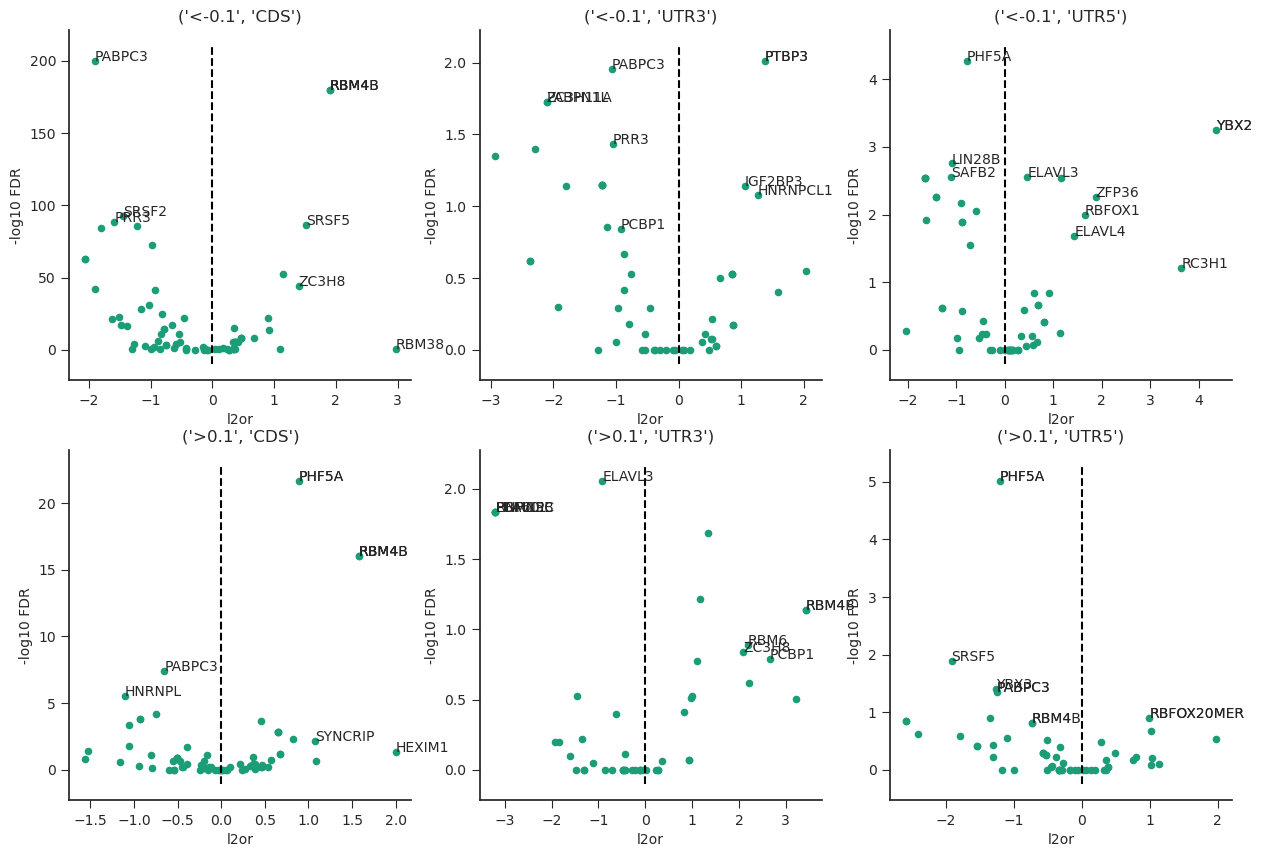

In [25]:
f, axes = plt.subplots(2,3, figsize = (15,10))
for ax, (name, group) in zip(axes.flatten(),stat.groupby(by = ['category', 'annotation'])):
    group.plot.scatter(x = 'l2or', y = '-log10 FDR', ax = ax)
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'odds ratio', ascending = False).iloc[:5]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:5]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['l2or'], row['-log10 FDR'], row['experiment'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()

In [26]:
contigency = np.array([[len(has_motif.intersection(positive)), len(positive-has_motif)],
                                  [len(has_motif.intersection(negative)), len(negative-has_motif)]]
                                 )

In [27]:
contigency

array([[      0,     118],
       [  33218, 2037267]])

In [28]:
pd.pivot_table(df, index = 'FASTA ID', columns = 'Motif Name', values = 'MotifScore')

Motif Name,AKAP8L_CCCGAG,CELF1_TTTGT,CELF3_GTGTGTGT,CELF4_GTGTGTG,CNOT4_ACAGA,CPEB1_TTTTTA,CSTF2T_CGTAGCGT,CSTF2_AGGCGTAGCGT,DAZ3_TGGTGCGTTTCCG,DAZAP1_TAGGTTAG,...,YBX3_ACAC,ZC3H11A_AAAAA,ZC3H12A_GCAGGTAAGTGC,ZC3H12C_AGGTAAGT,ZC3H18_GGGGG,ZC3H8_GCTTGC,ZFP36_TATTTA,ZFP36_TATTTATT,ZRANB2_GGTAA,ZRANB2_GGTAAGGT
FASTA ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.313245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,7.876501,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.313245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5722826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5722827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
